In [123]:
import numpy as np
import bigfloat as bf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
from scipy.special import jv, iv, eval_chebyt

## Supplementary Data for "Faster Coherent Quantum Algorithms for Phase, Energy, and Amplitude Estimation"
By Patrick Rall.

This Jupyter notebook which aims to make all the numerical work in [arXiv:2103.09717](https://arxiv.org/abs/2103.09717) as reproducible as possible. While the original numerical analysis was performed while PR was supported by Scott Aaronsons' Vannevar Bush Faculty Fellowship, this notebook was prepared while PR was at IBM Quantum.


## Outline

* Lemma 11: Polynomial approximations of $\text{sign}(x)$
* Lemma 14: Jacobi Anger expansion of $\cos(tx)$
* Lemma 17: Hamiltonian Simulation
* Proposition 5: Traditional Phase Estimation
* Corollary 13: Improved Phase Estimation
* Corollary 16: Improved Energy Estimation




## Lemma 11: Polynomial approximations of $\text{sign}(x)$

Resource estimation of the construction in Appendix A of [arXiv:1707.05391](https://arxiv.org/abs/1707.05391). In this subsection, the lemmas and equation numbers refer to that paper.

Method outline:
 1. (Lemmas 13,14) Approximate $p_\text{exp}(x) \approx e^{-\beta(x+1)}$ by truncating the Jacobi-Anger expansion
    $$ e^{-\beta(x+1)} = e^{-\beta} \left( I_0(\beta) + 2\sum_{j=1}^\infty I_j(\beta)T_j(-x) \right). $$
 2. (Corollary 3) Approximate $p_\text{gauss}(x) \approx e^{-(\gamma x)^2}$ via $p_\text{gauss}(x) = p_\text{erf}(2x^2 -1 )$ and $\gamma^2 = 2\beta$.
 3. (Corollary 4) Approximate $p_\text{erf}(x) \approx \text{erf}(kx)$ via $\gamma = k$ and
 $$p_\text{erf}(x) = \frac{2k}{\sqrt{\pi}} \int_{0}^x p_\text{gauss}(y)  dy. $$
 4. (Lemma 10) Approximate $p_\text{sign}(x) = p_\text{erf}(x) \approx \text{sign}(x)$ by setting $k$ large enough.


In [124]:


# bound on eps_exp from Lemma 13, equation 66
def exp_poly_degree(beta,error):
    out = bf.ceil(max(beta*bf.const_euler()**2, bf.log(2/error) ))
    out = 2 * out * bf.log(4/error)
    return bf.ceil(bf.sqrt(out))

# Corollary 3
def gauss_poly_degree(gamma,error):
    return exp_poly_degree((gamma**2)/2, error)


# Corollary 4, equation 70
def erf_poly_degree(k, error):
    # need to find n such that 4k/(sqrt(pi) n ) * gauss_error(k, n-1) < error
    # if we have converged then n = gauss_poly_degree(k, error*sqrt(pi)*n/(4*k))-1
    n = 1 # initial guess for n
    while True:
        if bf.is_nan(n): assert False
        new_n = gauss_poly_degree(k, error*bf.sqrt(bf.const_pi())*n/(4*k)) - 1
        if n > 1 and new_n >= n: break
        n = new_n
    return n

# Lemma 10
# Need to split error into p_erf ~ erf(kx) and erf(kx) ~ sign(x) parts
# parameter 0 < q < 1 determines which fraction to allocate
def sign_poly_degree_q(kappa,error,q):
    poly_erf_error = q*error
    erf_sign_error = (1-q)*error
    
    k = (bf.sqrt(2)/kappa) * bf.log( 2/(bf.const_pi() * erf_sign_error**2) )**(1/2)
    
    return erf_poly_degree(k,poly_erf_error)

What is a good choice for $q$? It seems $q = 0.4$ is best.

Text(0, 0.5, 'Degree of $p_{erf}$')

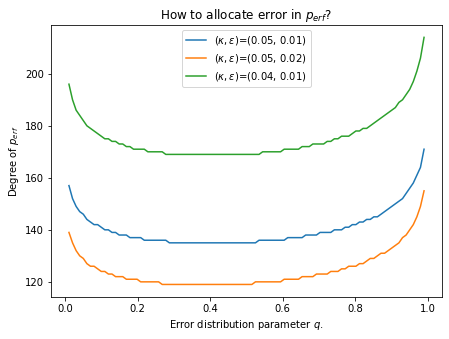

In [125]:
for (kappa,error) in [(0.05,0.01),(0.05,0.02),(0.04,0.01)]:
    plt.plot(np.linspace(0.01,0.99,100), 
             [sign_poly_degree_q(kappa,error,q)
                  for q in np.linspace(0.01,0.99,100)],
             label="($\\kappa,\\varepsilon$)="+str((kappa,error)))
plt.legend()
plt.title("How to allocate error in $p_{erf}$?")
plt.xlabel("Error distribution parameter $q$.")
plt.ylabel("Degree of $p_{erf}$")

In [126]:
# Turns out q = 0.4 is a good choice.
def sign_poly_degree(kappa,error):
    return sign_poly_degree_q(kappa,error,0.4)

To get an amplifying polynomial $A_{\eta\to\delta}$, we select $\kappa = 4\eta$ and $\varepsilon = \delta/2$.

In [127]:
def amp_poly_M(eta,delta):
    kappa = 4*eta
    error = delta/2
    return sign_poly_degree(kappa,error)

In [128]:
#plt.plot(range(3,30),
#    [amp_poly_M(0.01,bf.exp10(-d)) for d in range(3,30)])
#plt.grid()

## Lemma 14: Jacobi Anger expansion of $\cos(tx)$

Let:
    $$r(t',\varepsilon') := \text{the soln to } \varepsilon' = (t'/r)^r \text{ for } r > t'$$
    $$ R := \left\lfloor r(et/\varepsilon, (5/4)\varepsilon   ) \right\rfloor $$
    
Then $p_{\text{cos},t} \approx \cos(tx)$ where:
$$p_{\text{cos},t} = J_0(t) + 2 \sum_{k=1}^R (-1)^k J_{2k}(t) T_{2k}(x)$$

$p_{\text{cos},t}$ has degree $2R$.

In [129]:
def ja_r(t_p,eps_p):
    maxOut = bf.BigFloat(t_p) # start at minimum value

    # keep doubling maxOut until bigger than threshold
    while (t_p / maxOut)**maxOut > eps_p: maxOut *= 2
    minOut = maxOut/2 # must be below threshold

    # r is getting rounded later, it doesn't need to be so precise
    while maxOut - minOut > 0.001:
        assert (t_p / maxOut)**maxOut < eps_p
        assert (t_p / minOut)**minOut > eps_p
        med = (maxOut + minOut)/2
        if (t_p / med)**med > eps_p: minOut = med
        else: maxOut = med
            
    return med

def ja_cos_degree(t,eps):
    eps_p = (5/4)*eps
    t_p = np.e*abs(t)/2
    return 2*int( ja_r(t_p, eps_p) )

In [130]:
#ja_r(128,0.01)

## Lemma 17: Hamiltonian Simulation

Given a block encoding of $H$, we can implement a channel $\varepsilon$-close in diamond norm to $e^{i H t}$ with this many queries to the block encoding:

$$ 3 \cdot r\left( \frac{et}{2} , \frac{\varepsilon}{24} \right) + 3 $$


In [131]:
def hamiltonian_simulation(t, eps): 
    t_p = (bf.const_euler()/2)*abs(t)
    eps_p = eps/24
    return 3 * ja_r(t_p, eps_p) + 3

## Proposition 5: Traditional Phase Estimation

Let
$$ \gamma(x) = \frac{\sin^2(\pi x)}{\pi^2 x^2}  $$
$$\eta_0 = \frac{8}{\pi^2} - \frac{1}{2} $$
$$ \delta_\text{med} = \frac{\delta^2}{6.25} $$

If $\alpha \leq 1/2$, let $r = \lceil \log_2 ( \frac{1}{2\alpha} ) \rceil$. The query complexity is:
$$ (2^{n+r} - 1) \cdot \left\lceil \frac{ \ln(\delta^{-1}_\text{med}) }{2 \eta_0^2}  \right\rceil $$

If $\alpha > 1/2$, the query complexity is:
$$ (2^{n} - 1) \cdot \left\lceil \frac{ \ln(\delta^{-1}_\text{med}) }{2 \eta^2}  \right\rceil $$



In [132]:
def traditional_phase_estimation(alpha,delta,n):
    
    delta_med = delta**2 / 6.25
    
    if alpha <= 0.5:
        eta_0 = (8 / bf.const_pi()**2) - 0.5
        r = bf.ceil(  bf.log2( 1 / (2*alpha) ) )
        return (2**(n+r) - 1) * bf.ceil( bf.log(1/delta_med) / (2*eta_0**2) ) 
        
    else:
        gamma = lambda x : bf.sin(bf.const_pi()*x)**2 / (bf.const_pi() * x)**2
        eta = gamma( (1-alpha)/2 ) - 0.5
        
        return (2**n - 1) * bf.ceil( bf.log(1/delta_med) / (2*eta**2) ) 

To perform energy estimation the traditional way, we just use traditional phase estimation with the $e^{i t H}$ oracle constructed above. The only technical question is how to distribute the error $\delta$ over the $e^{i t H}$ oracles and the phase estimation algorithm.

From [1806.01838](https://arxiv.org/abs/1806.01838) we know that:
$$r(t,\varepsilon) \in \Theta\left(t + \frac{\ln(1/\varepsilon)}{\ln(e + \ln(1/\varepsilon)/t)}\right) \subset O\left(t + \ln(1/\varepsilon)\right)$$
The total runtime for several $t_i, \varepsilon_i$ is then:
$$\sum_i r(t_i,\varepsilon_i) \in  O\left(\sum_i t_i + \sum_i \ln(1/\varepsilon_i)\right)$$
We see the $t_i$ just factor out, and if the goal is to achieve $\sum_i \varepsilon_i = \varepsilon_\text{sim}$ then spreading the errors out uniformly over the $\varepsilon_i$ is best.

As for how to split the error $\delta$ over Hamiltonian simulation and phase estimation, we do a search over $m$ with $\delta_\text{pe} = \delta (1 - 2^{-m})$ and $\varepsilon_\text{sim} = \delta 2^{-m}$. We expect making $\varepsilon_\text{sim}$ small to be much cheaper than making $\delta_\text{pe}$ small, because the corresponding runtimes are proportional to $(n+r) \ln(1/\varepsilon_\text{sim}  )$ and $2^{n+r} \ln(1/\delta_\text{pe})$.

In [133]:
def traditional_energy_estimation_m(alpha,delta,n,m):
    delta_pe = delta * (1-bf.exp2(-m))
    eps_sim = delta * bf.exp2(-m)
    
    delta_med = delta_pe**2 / 6.25

    if alpha <= 0.5:
        eta = (8 / bf.const_pi()**2) - 0.5
        r = int(bf.ceil(  bf.log2( 1 / (2*alpha))))
    else:
        gamma = lambda x : bf.sin(bf.const_pi()*x)**2 / (bf.const_pi() * x)**2
        eta = gamma( (1-alpha)/2 ) - 0.5
        r = 0
            
    total_sim_cost = 0
    for i in range(n+r):
        #delta_targ = bf.exp2(-i) * eps_sim/2 # geometric error distribution
        delta_targ = eps_sim/(n+r) # uniform error distribution. Seems no different.
        total_sim_cost += hamiltonian_simulation(2*bf.const_pi()*2**i, delta_targ)
        
    amp_repetitions = bf.ceil( bf.log(1/delta_med) / (2*eta**2) ) 

    return total_sim_cost * amp_repetitions



Playing around with this cost function, we see that the optimal value of $m$ is always between 1 and 6. 

Text(0.5, 1.0, 'What is a good value of $m$ for phase estimation?')

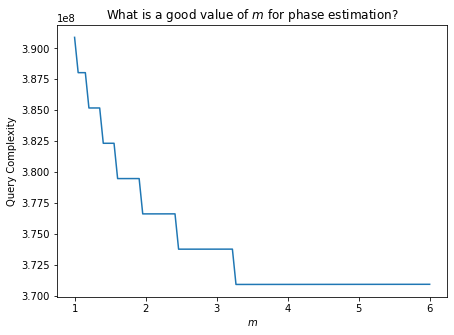

In [219]:
ms = np.linspace(1,6,100)
costs = [traditional_energy_estimation_m(0.001, bf.exp10(-5), 10, m) for m in ms]
plt.plot(ms,costs)
plt.xlabel("$m$")
plt.ylabel("Query Complexity")
plt.title("What is a good value of $m$ for phase estimation?")

So we just perform a brute force search to get the best value. I also played around with plotting the optimal $m$ as a function of $\alpha,\delta,n$ and found that $m$ does vary quite a bit! So we can't just pick out a single $m$ for everything.

In [135]:
def traditional_energy_estimation(alpha,delta,n):
    ms = np.linspace(1,6,100)
    return min([traditional_energy_estimation_m(alpha, delta, n, m) for m in ms])

## Corollary 13: Improved Phase Estimation

From Theorem 12, if $M_\eta \to \delta_\text{amp}$ is the degree of the quantum amplifying polynomial, then the cost of the $k$'th step is:
$$ 2^{n-k} \cdot M_{\eta \to \delta_\text{amp}} $$

When $k = 0$ we have $\eta_k = \alpha/2$, and if $k \geq 1$ then
$$ \eta_k = \frac{1}{2} - \frac{1}{2^k} \left( \frac{1}{2} + \frac{\alpha}{2} \right)$$

If the error on the $k$'th iteration is $\delta_k$, we can make $\delta_\text{amp}$ arbitrarily close to $\delta_k^2/8$, because of the additional error of computing phase angles for quantum signal processing. We neglect this error here.

Following Corollary 13, we set $\delta_k = \delta \cdot 2^{-k-1}$.





In [136]:
def improved_phase_estimation(alpha,delta,n):
    
    out = 0

    for k in range(0,n):
        delta_k = bf.exp2(-k) * delta/2
            
        delta_amp = delta_k**2 / 8
        
        if k == 0: eta_k = alpha/2
        else: eta_k = 0.5 - (0.5 + alpha/2)/2**k

        # Figure 3 shows that the amplification gap is at least eta_k,
        # but it's actually a little bigger than that. We can compute
        # it directly, and this makes a big difference!
        # We have cos^2(pi x) = 1/2 at x = -1/4.
        # Line in figure is y = 1/2 + 2(x + 1/4).
        # 1/2 + 2(x + 1/4) = 1/2 + eta_k at x = eta_k/2 - 1/4.
        # Gap is cos^2(pi x) - 1/2 at that value of x.
        eta_k = bf.sin(bf.const_pi() * (eta_k/2 + bf.exp2(-2)))**2 - bf.exp2(-1)
        
        out += 2**(n-k) * amp_poly_M(eta_k,delta_amp)

    return int(out)

## Corollary 16: Improved Energy Estimation

As with traditional energy estimation, we need to decide how to spread the error out between phase estimation and the Jacobi-Anger expansion. Looking at Theorem 15, we again neglect $m_\text{svt}$ and only focus on $m = m_\text{cos}$.

The cost of the $k$'th iteration is then:
$$ 4 \cdot M_{(1-10^{-m})\eta_k \to \delta_\text{amp}} \cdot \left\lceil r\left( \frac{e}{2} \pi 2^{n-k} , \frac{5}{4} \frac{\eta_k}{2} 10^{-m} \right)  \right\rceil $$

where $\eta_k$ and $\delta_\text{amp}$ are the same as for phase estimation.

In [137]:
def improved_energy_estimation_step_m(eta_k,delta_amp,n,k,m):
    
    eta_amp = eta_k * (1-10**(-m))
    eta_cos = eta_k * 10**(-m)
    
    t_p =  (bf.const_euler()/2)*bf.const_pi()*bf.exp2(n-k)
    eps_p = (5/4) * eta_cos / 2
    cos_degree = ja_r(t_p,eps_p)
    
    amp_degree = amp_poly_M(eta_amp,delta_amp)
    
    return 4 * amp_degree * np.ceil( cos_degree )

Playing around with this cost function, we again see that the optimal value of $m$ is always between 1 and 6. 

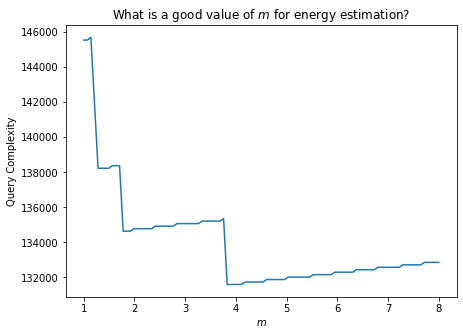

In [220]:
with bf.precision(100):
    ms = np.linspace(1,8,100)
    costs = [improved_energy_estimation_step_m(0.2,bf.exp10(-10), 10, 0, m) for m in ms]
    plt.plot(ms,costs)
    plt.xlabel("$m$")
    plt.ylabel("Query Complexity")
    plt.title("What is a good value of $m$ for energy estimation?")

In [139]:
def improved_energy_estimation_step(eta_k,delta_amp,n,k):
    ms = np.linspace(1,5,100)
    return min([improved_energy_estimation_step_m(eta_k,delta_amp,n,k,m) for m in ms])

In [221]:
def improved_energy_estimation(alpha,delta,n):
    out = 0

    for k in range(0,n):
        delta_k = bf.exp2(-k) * delta/2
            
        delta_amp = delta_k**2 / 8
        
        if k == 0: eta_k = alpha * bf.exp2(-1)
        else: eta_k = bf.exp2(-1) - bf.exp2(-k-1) *(1 + alpha)
        
        eta_k = bf.sin(bf.const_pi() * (eta_k/2 + bf.exp2(-2)))**2 - bf.exp2(-1)

        out += improved_energy_estimation_step(eta_k,delta_amp,n,k)

    return int(out)

## Summary

We want to compare:
* TRAD_PE Traditional Phase Estimation (Proposition 5) without garbage (Lemma 3)
* IMPR_PE_PH Improved Phase Estimation (Corollary 13) with phases
* IMPR_PE Improved Phase Estimation (Corollary 13) without phases (Lemma 3)
* TRAD_EE Traditional Energy Estimation via Corollary 13 and Hamiltonian simulation (Lemma 17) without garbage (Lemma 3)
* IMPR_EE Improved Energy Estimation (Corollary 13) without garbage (Lemma 3)



In [141]:

def wrap(f, log_alpha=None, log_delta=None, n=None, prec=None):
    with bf.precision(prec):
        alpha = bf.exp2(-log_alpha)
        delta = bf.exp10(-log_delta)
        return int(f(alpha,delta,n))

# Lemma 3 just multiples the query complexity by 2
    
def TRAD_PE(**kwargs):
    return wrap(traditional_phase_estimation, **kwargs) * 2

def IMPR_PE_PH(**kwargs):
    return wrap(improved_phase_estimation, **kwargs) # No Lemma 3!
    
def IMPR_PE(**kwargs):
    return wrap(improved_phase_estimation, **kwargs) * 2
    
def TRAD_EE(**kwargs):
    return wrap(traditional_energy_estimation, **kwargs) * 2

def IMPR_EE(**kwargs):
    return wrap(improved_energy_estimation, **kwargs) * 2
    


## Data Caching

In [142]:

cache_file = "phase_estimation_performance_cache.txt"

# attempts to retrieve the value from cache.
# if it's not in there, computes the value and writes it to cache.
def get_function_value(func, log_alpha=None, log_delta=None, n=None, prec=None):
    # sanitize values
    log_alpha = np.round(float(log_alpha),2)
    log_delta = np.round(float(log_delta),2)
    n, prec = int(n), int(prec)
    
    this_key = json.dumps([func.__name__,log_alpha,log_delta,n,prec])
    
    # try to find the key in the cache file
    with open(cache_file) as f:
        for l in f.readlines():
            key,value = json.loads(l.strip())
            if key == this_key: return value 
    
    # couldn't find it, so evaluate it 
    value = func(log_alpha=log_alpha, log_delta=log_delta, n=n, prec=prec)
    
    # append to cache
    with open(cache_file,"a") as f:
        f.write(json.dumps([this_key,value])+"\n")
    
    return value

# returns tuple of lists (xvals, costs).
# exactly one of the kwargs is a list of numbers, others need to be numbers.
# Example usage: plt.plot( *get_data(log_alpha=np.linspace(1,10,11),
#                                    log_delta=30, n=10, prec=100)).
def get_data(func, **kwargs):
    
    # determine which of the arguments was the list
    list_key = None
    for key in kwargs.keys():
        try:
            xvals = list(kwargs[key])
            # cast to list succeded!
            assert list_key is None
            list_key = key
        except:
            pass
    assert list_key is not None
    
    # a dictionary for sweeping through the value
    iter_kwargs = {}
    for key in kwargs.keys():
        if key != list_key:
            iter_kwargs[key] = kwargs[key]
    
    out = []
    for i, x in enumerate(xvals):
        print(i+1,"of",len(xvals),10*" ", end="\r")
        iter_kwargs[list_key] = x
        out.append(get_function_value(func, **iter_kwargs))
    
    return xvals, out


## Some parameter choices

In [143]:

# Data ranges considered. Changing these requires re-running the simulation, as the data might not be cached.
range_alpha = {"log_alpha": np.linspace(1,10,9*3+1), "log_delta": 30, "n": 10, "prec": 100}
range_delta = {"log_alpha": 10, "log_delta": range(1,40), "n": 10, "prec": 100}
range_n = {"log_alpha": 10, "log_delta": 30, "n": range(5,20), "prec": 100}

# These data are also in the cache:
#range_alpha = {"log_alpha": np.linspace(1,20,19*3+1), "log_delta": 30, "n": 10, "prec": 100}

for kwargs in [range_alpha, range_delta, range_n]:
    get_data(TRAD_PE,**kwargs)
    get_data(IMPR_PE_PH,**kwargs)
    get_data(IMPR_PE,**kwargs)
    get_data(TRAD_EE,**kwargs)
    get_data(IMPR_EE,**kwargs)
    

## Plotting query complexity

In [211]:
# Information on how to visualize the different series in matplotlib
series_kwargs = {
    "TRAD_PE": { 
        "label":"Traditional Phase Estimation (Proposition 5) without Garbage (Lemma 3)",
        "marker":'^', "linewidth":1, "markersize":4, "linestyle":"solid","color":"black",
    },
    "IMPR_PE_PH": { 
        "label":"Improved Phase Estimation (Corollary 13) with Phases",
        "marker":'D', "linewidth":1, "markersize":4, "linestyle":"solid","color":"black",
    },
    "IMPR_PE": { 
        "label":"Improved Phase Estimation (Corollary 13) without Phases (Lemma 3)",
        "marker":'s', "linewidth":1, "markersize":4, "linestyle":"solid","color":"black",
    },
    "TRAD_EE": { 
        "label":"Energy Estimation via Traditional Phase Estimation (Proposition 5)\n without Garbage (Lemma 3) and Hamiltonian Simulation (Lemma 17)",
        "marker":'o', "linewidth":1, "markersize":4, "linestyle":"solid","color":"black",
    },
    "IMPR_EE": { 
        "label":"Improved Energy Estimation without Garbage (Corollary 16)",
        "marker":'x', "linewidth":1, "markersize":4, "linestyle":"solid","color":"black",
    },
    "TRAD_PE/IMPR_PE_PH": {
        "label":"Phase Estimation (Corollary 13 vs Proposition 5 + Lemma 3)",
        "marker":'P', "linewidth":1, "markersize":6, "linestyle":"solid","color":"black",
    },
    "TRAD_EE/IMPR_EE": {
        "label":"Energy Estimation (Corollary 16 vs Proposition 5 + Lemma 3 + Lemma 17)",
        "marker":'*', "linewidth":1, "markersize":6, "linestyle":"solid","color":"black",
    },
}

In [230]:
# A unified plotting script.
# Takes: 
#     fs: what series to plot.
#        a list of functions from the set [TRAD_PE IMPR_PE_PH,IMPR_PE,TRAD_EE,IMPR_EE]
#         -- or --
#        a list of 2-tuples of those functions, representing their ratio
#     xvar: what to put on the x axis
#        one of "alpha", "delta", or "n"

def plot_query_complexity(fs, xvar):
    assert xvar in ["alpha","n","delta"]
    plt.rcParams['figure.figsize'] = [7, 3]

    _, ax = plt.subplots()
    if xvar == "alpha":
        for fp in fs:
            if isinstance(fp,tuple):
                _, queries0 = get_data(fp[0],**range_alpha)
                log_alphas, queries1 = get_data(fp[1],**range_alpha)
                ax.plot([2**(log_alpha) for log_alpha in log_alphas],
                        [a/b for a,b in zip(queries0,queries1)],
                        **series_kwargs[fp[0].__name__+"/"+fp[1].__name__])
            else:
                log_alphas, queries = get_data(fp,**range_alpha)
                ax.plot([2**(log_alpha) for log_alpha in log_alphas],
                        queries, **series_kwargs[fp.__name__])

        ax.set_xlabel("$\\alpha$")
        ax.set_xscale("log")

        xticks, xtick_labels = zip(*[(float(2**(log_alpha)),"$2^{-"+str(int(log_alpha))+"}$") 
                                    for log_alpha in log_alphas 
                                    if log_alpha == int(log_alpha)])
        ax.set_xticks([tick+j*tick/4 for tick in xticks for j in range(4)][:-3], minor=True)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_xticklabels([""]*(len(xticks)*4-3),minor=True)

    if xvar == "delta":
        for fp in fs:
            if isinstance(fp,tuple):
                _, queries0 = get_data(fp[0],**range_delta)
                log_deltas, queries1 = get_data(fp[1],**range_delta)
                ax.plot([10**(log_delta) for log_delta in log_deltas],
                        [a/b for a,b in zip(queries0,queries1)],
                        **series_kwargs[fp[0].__name__+"/"+fp[1].__name__])
            else:
                log_deltas, queries = get_data(fp,**range_delta)
                ax.plot([10**(log_delta) for log_delta in log_deltas],
                        queries, **series_kwargs[fp.__name__])

        ax.set_xlabel("$\\delta$")
        ax.set_xscale("log")

        xticks, xtick_labels = zip(*[(float(10**(log_delta)),"$10^{-"+str(int(log_delta))+"}$") 
                                    for log_delta in log_deltas 
                                    if log_delta % 4 == 1])
        ax.set_xticks([tick+j*10**4*tick/10 for tick in xticks for j in range(10)][:-9], minor=True)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)
        ax.set_xticklabels([""]*(len(xticks)*10-9),minor=True)


    if xvar == "n":
        for fp in fs:
            if isinstance(fp,tuple):
                _, queries0 = get_data(fp[0],**range_n)
                ns, queries1 = get_data(fp[1],**range_n)
                ax.plot([n for n in ns],
                        [a/b for a,b in zip(queries0,queries1)],
                        **series_kwargs[fp[0].__name__+"/"+fp[1].__name__])
            else:
                ns, queries = get_data(fp,**range_n)
                ax.plot([n for n in ns],
                        queries, **series_kwargs[fp.__name__])

        ax.set_xlabel("$n$")


    plt.legend()
    plt.grid()
    if isinstance(fs[0],tuple):
        plt.ylabel("Query Complexity Multiplicative Speedup")
    else:
        plt.ylabel("Query Complexity")
        plt.yscale("log")

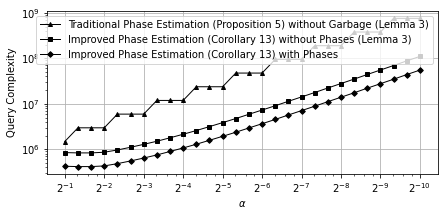

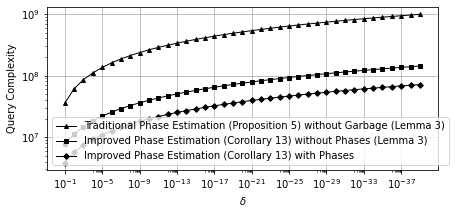

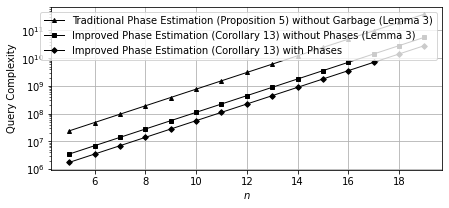

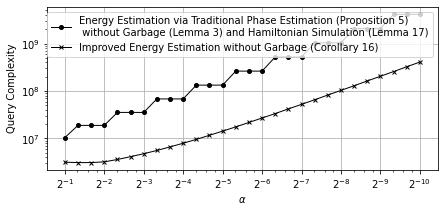

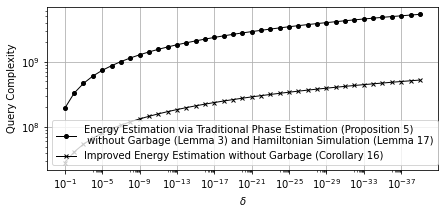

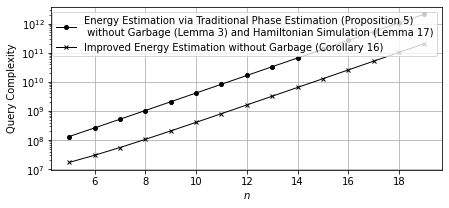

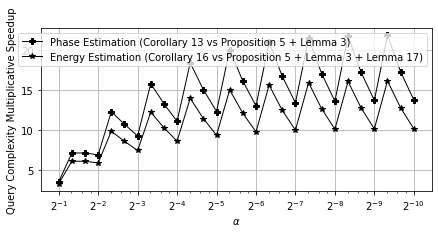

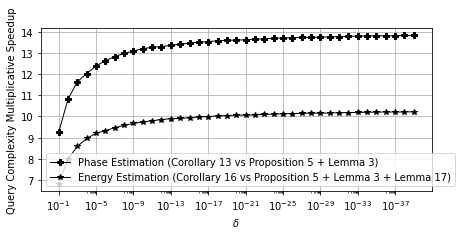

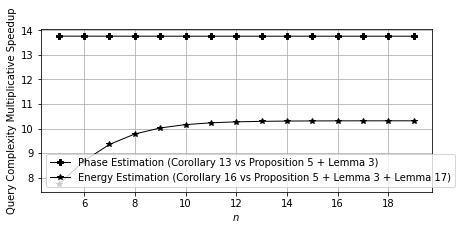

In [231]:
# Plot everything.

# All possible series: Phase Estimation, Energy Estimation, and their speedups
for fs in [[TRAD_PE,IMPR_PE,IMPR_PE_PH],[TRAD_EE,IMPR_EE],[(TRAD_PE,IMPR_PE_PH),(TRAD_EE,IMPR_EE)]]:
    
    # All possible parameters: alpha,delta,n
    for mode in ["alpha","delta","n"]:
        plot_query_complexity(fs,mode)
        plt.show()
